In [ ]:
#Negrete
#could be used to resize our images when creating dataset
##Fit the data into a 256*256 format and save it as a .tif file
#Sukriti Paul

#from PIL import Image
#from skimage import data, io, filters
#import numpy as np
#from scipy import ndimage
#from matplotlib import pyplot as plt
#from sklearn import manifold, datasets

#n=10 #number of images
#for i in range (1,n+1):
	#path=str(i)+'.png'
	#img= io.imread('/Users/sukritipaul/Desktop/D004/test_annotate/'+path)
	#Subsection of the image
	#img=img[52:308,52:308] Original image was 360 x 360, 
	#print img.shape
	#path=str(i)+'.tif'
	#io.imsave('/Users/sukritipaul/Desktop/D004/AlteredDims/tiff_form_test_annotate/'+path,img)


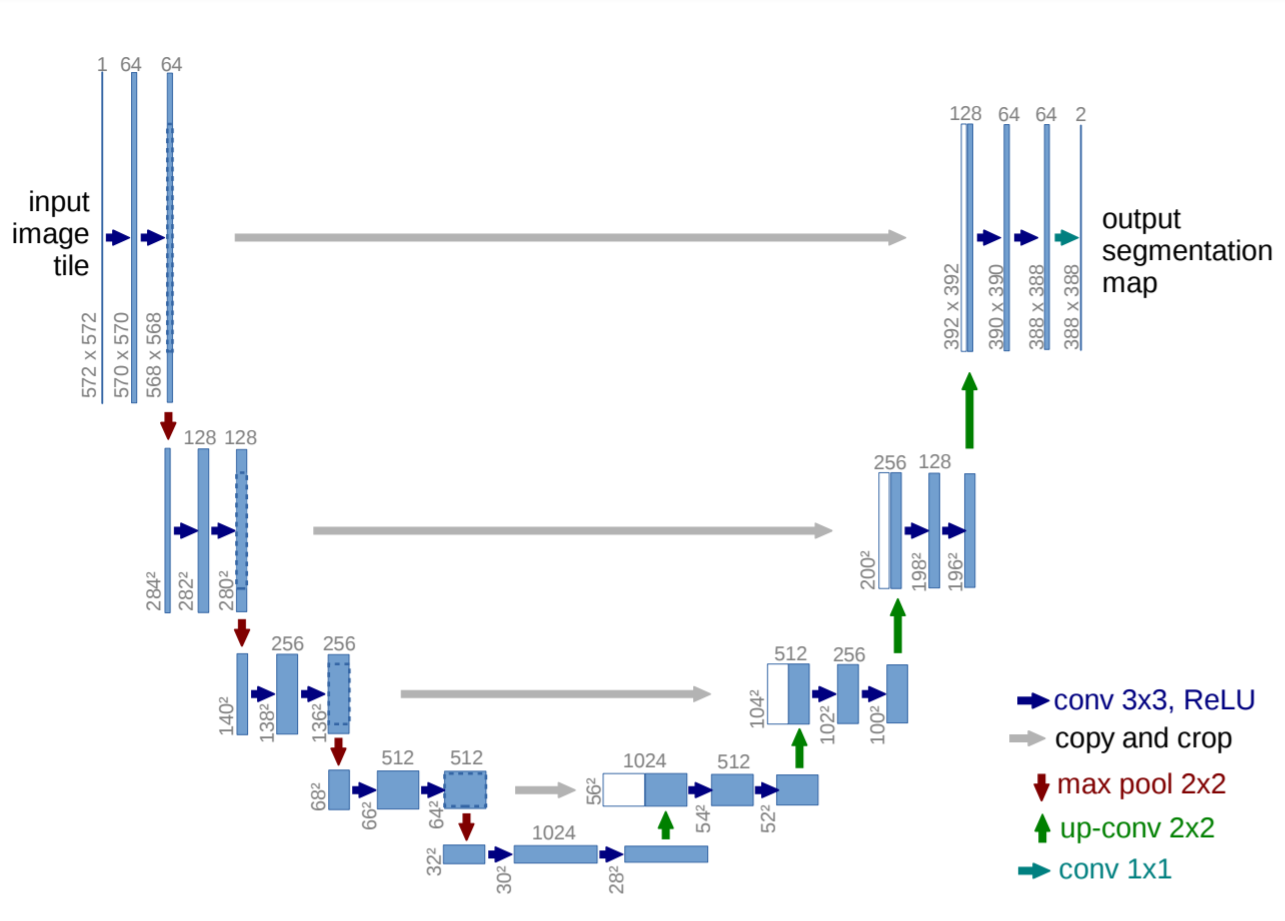

In [ ]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import torchvision

In [ ]:
def double_conv(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size = 3),
      nn.ReLU(inplace = True),
      nn.Conv2d(out_c, out_c, kernel_size = 3),
      nn.ReLU(inplace = True)
  )
  return conv

def crop_img(tensor, target_tensor):
  target_size = target_tensor.size()[2]
  target1_size = target_tensor.size()[3]
  
  tensor_size = tensor.size()[2]
  tensor1_size = tensor.size()[3]
  delta = tensor_size - target_size
  delta = delta // 2
  delta1 = tensor1_size - target1_size
  delta1 = delta1 // 2
  return tensor[:, :, delta:tensor_size - delta, delta1:tensor1_size - delta1]



class UNET(nn.Module):
  def __init__(self):
    super(UNET, self).__init__()

    self.max_pool_2x2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.down_conv_1 = double_conv(1, 64)
    self.down_conv_2 = double_conv(64, 128)
    self.down_conv_3 = double_conv(128, 256)
    self.down_conv_4 = double_conv(256, 512)
    self.down_conv_5 = double_conv(512, 1024)

    self.up_trans_1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
    self.up_conv_1 =  double_conv(1024, 512)
    
    self.up_trans_2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
    self.up_conv_2 =  double_conv(512, 256)

    self.up_trans_3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
    self.up_conv_3 =  double_conv(256, 128)
   
    self.up_trans_4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
    self.up_conv_4 =  double_conv(128, 64)

    self.out = nn.Conv2d(
        in_channels = 64,
        out_channels = 2, ##more images to segment? increse this number
        kernel_size = 1
    )

  
  def forward(self, image):
    x1 = self.down_conv_1(image)#
    x2 = self.max_pool_2x2(x1)
    x3 = self.down_conv_2(x2)#
    x4 = self.max_pool_2x2(x3)
    x5 = self.down_conv_3(x4)#
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv_4(x6)#
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv_5(x8)
  
    x = self.up_trans_1(x9)
    y = crop_img(x7, x)
    print(y.size())
    x = self.up_conv_1(torch.cat([x, y], 1))

    x = self.up_trans_2(x)
    y = crop_img(x5, x)
    print(y.size())
    x = self.up_conv_2(torch.cat([x, y], 1))

    x = self.up_trans_3(x)
    y = crop_img(x3, x)
    print(y.size())
    x = self.up_conv_3(torch.cat([x, y], 1))

    x = self.up_trans_4(x)
    y = crop_img(x1, x)
    print(y.size())
    x = self.up_conv_4(torch.cat([x, y], 1))

    x = self.out(x)
    print(x.size())
    return x

if __name__ == "__main__":
  image = torch.rand(1 , 1, 1280, 1280) #image size when
  #i do 1280, 720 then output is 72, 37
  model = UNET()
  print(model(image))
  

torch.Size([1, 512, 144, 144])
torch.Size([1, 256, 281, 281])


RuntimeError: ignored